# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
# импорт библиотеки pandas
import pandas as pd

# чтение файла с данными и сохранение в data
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')

общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  ai

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

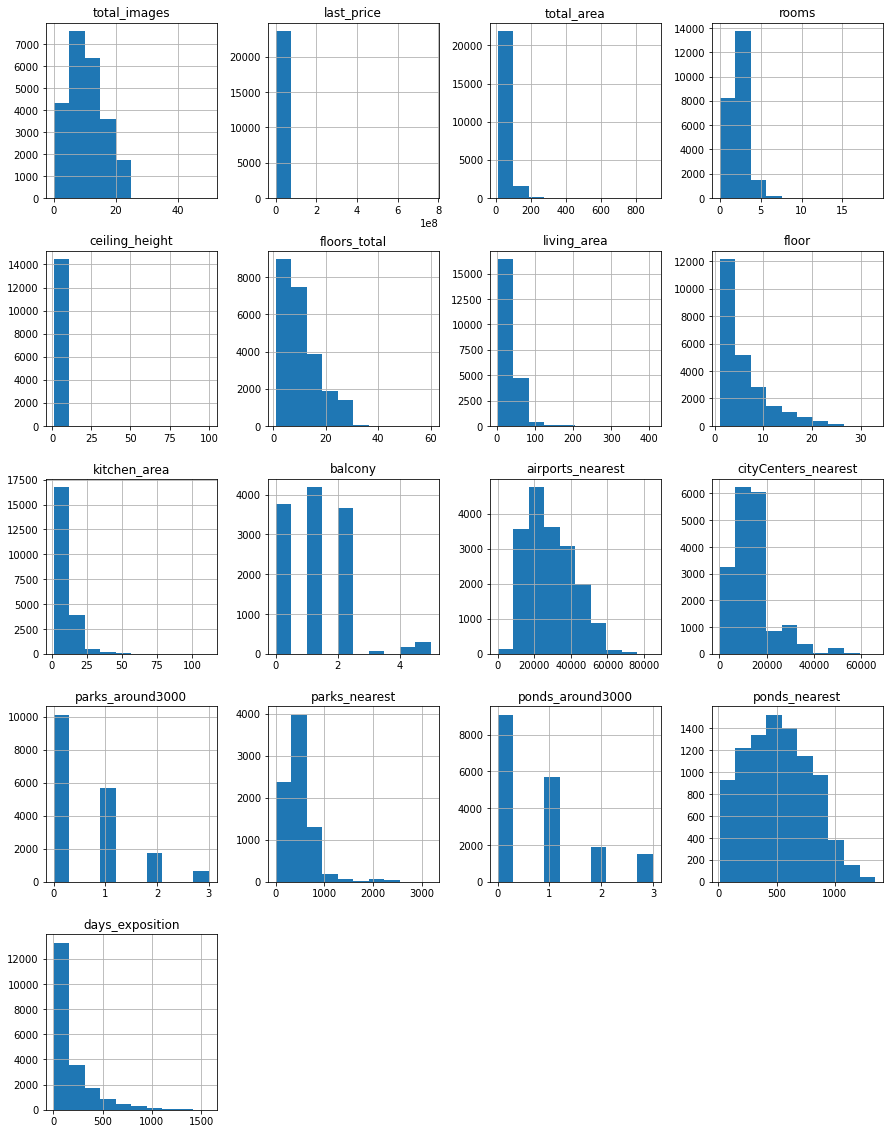

In [2]:
# получение общей информации о данных в таблице df
print('общая информация')
data.info()
print()

# поиск кол-ва пропущенных значений по столбцам
print('кол-во пропущенных значений по столбцам')
print(data.isna().sum())
print()

# получение первых 10 строк таблицы df
print('первые десять строк таблицы')
print(data.head(10))
print()

# поиск явных дубликатов в датасете
duplicate_row = data[data.duplicated ()]
# как мы можем видеть - дубликатов в датасете нет
print(duplicate_row)

# строим гистограммы по каждому столбцу для визуального ознакомления
print('гистограммы для ознакомления')
data.hist(figsize=(15, 20))

## Предобработка данных
Для начала ищем тип данных в каждом столбце. Далее считаем пропуски в каждом столбце и выводим таблицу для визуального ознакомления. По порядку начинаем исправлять пропущенные и аномальные значения в столбцах

### ceiling_height. 
Используем метод describe(). Видим что есть аномальные значения в виде min и max. Строим гистограмму по значениям меньше 2 (очень много значений, если строить по первому квантилю - аномальные значения становятся не видны). Предположим, что потолки высотой 2 метра существуют, но все то, что ниже - явно выброс. Отбрасываем их. Строим гистограмму по значениям больше 2.8. Очевидный выброс с потолком в 100 м. Ограничимся значениями от 5 до 50 м (на промежутке от 50 до 100 м других значений, кроме 100 - нету), чтобы найти другие аномалии. Предположим, что квартир с потолками выше 5 м - не существует. Тогда значения от 5 до 20 м мы выбрасываем. А значения больше 20 м - очень похожи на опечатку. Их мы просто поделим на 10. Пропущенные значения заполним медианой. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора.

общая информация
count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64
гистограммы по параметру


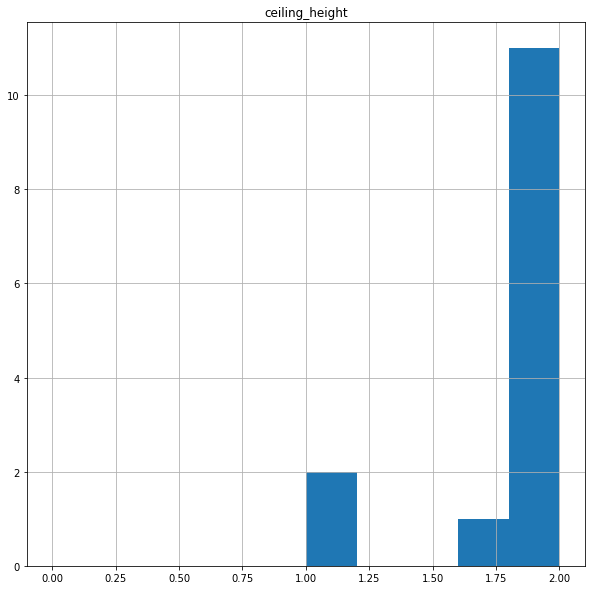

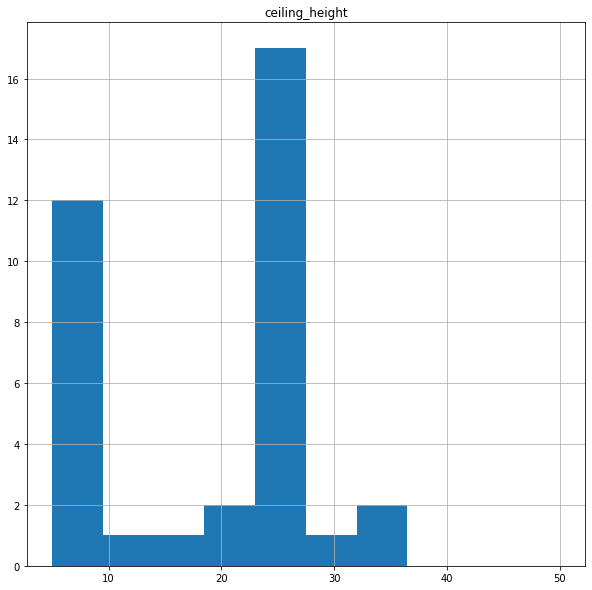

In [3]:
print('общая информация')
print(data['ceiling_height'].describe())
# Сортируем значения левее первого квантиля
height_min = data[data['ceiling_height'] < 2.52]
print('гистограммы по параметру')
height_min.hist(column = 'ceiling_height', grid=True, figsize=(10,10), range=(0, 2))
# Отбрасываем аномалии
data = data[~(data['ceiling_height'] < 2)]
# Сортируем значения правее третьего квантиля
height_max = data[data['ceiling_height'] > 2.8]
height_max.hist(grid=True, column = 'ceiling_height', figsize = (10,10), range=(5, 50))
# Преобразовываем ошибки в нормальные значения
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x / 10 if x > 20 else x)
# Отбрасываем аномалии
data = data[~((data['ceiling_height'] > 5) & (data['ceiling_height'] <= 20))]
# Заполняем пропущенные значения медианой
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace = True)

### floors_total. 
Используем метод describe(). 60 этажей вполне может быть.Пропущенные значения отбросим. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Тип данных переведен в int, 2,5 этажей не бывает.

общая информация
count    23595.000000
mean        10.674168
std          6.595832
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

гистограмма по параметру


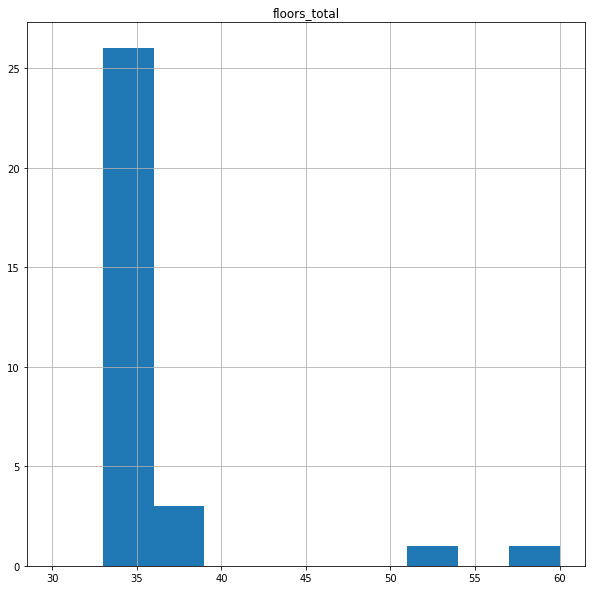

In [4]:
print('общая информация')
print(data['floors_total'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'floors_total', grid=True, figsize=(10,10), range=(30,60))
# Отбрасываем пропущенные значения
data.dropna(subset = ['floors_total'], inplace = True)

### living_area. 
Используем метод describe(). Видим что есть аномальные значения в виде min. Строим гистограмму по значениям меньше 18 м. Отбрасываем значения меньше 15 м (сомневаюсь, что какой-либо застройщик станет строить квартиры у которых метраж меньше 15 м). Квартиры с метражом 300-400 м2 - это 6-комнатные квартиры, так что такое может быть. Пропущенные значения заполним медианой.

общая информация
count    21727.000000
mean        34.444689
std         21.984783
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

гистограмма по параметру


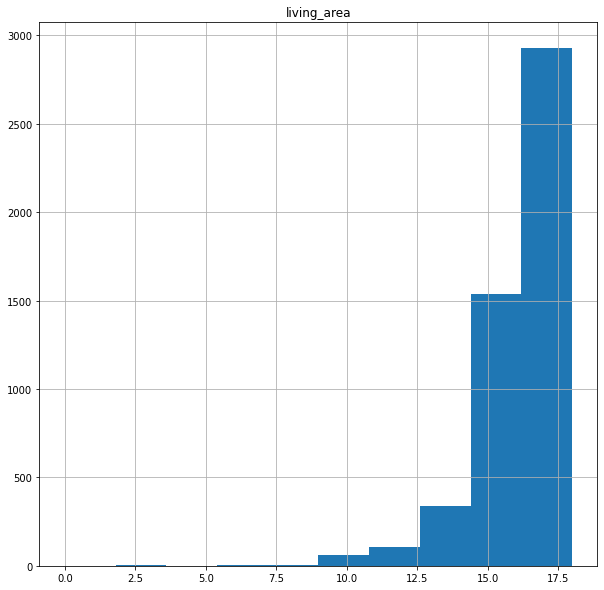

In [5]:
print('общая информация')
print(data['living_area'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'living_area', grid=True, figsize=(10,10), range=(0, 18))
# Отбрасываем аномалии
data = data[~(data['living_area'] < 15)]
# Заполняем пропущенные значения медианой
data['living_area'].fillna(data['living_area'].median(), inplace = True)

### is_apartment. 
Заменим все пропущенные значения 0. Скорее всего информации нету потому, что помещение не является апартаментами. А также пропущенные значения могли появится при технических неполадках или из-за человеческого фактора.

In [6]:
# Заполняем пропущенные значения 0
data['is_apartment'].fillna(False, inplace = True)

### kitchen_area. 
Используем метод describe(). Видим что есть аномальные значения в виде min и max. Строим гистограмму по значениям меньше 7 м2. Значения меньше 5 м2 отбрасываем. Строим гистограмму по значениям больше 30 м2 (это то, насколько большими могут быть кухни - максимум который я нашел). Тогда имеем, что значения от 30 до 50 м2 мы отбрасываем, а значения от 50 до 112 м2 могут быть опечаткой - тогда поделим их на 10. Пропущенные значения заполним медианой. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора.

общая информация
count    20734.00000
mean        10.53087
std          5.91551
min          1.30000
25%          7.00000
50%          9.00000
75%         12.00000
max        112.00000
Name: kitchen_area, dtype: float64

гистограмма по параметру


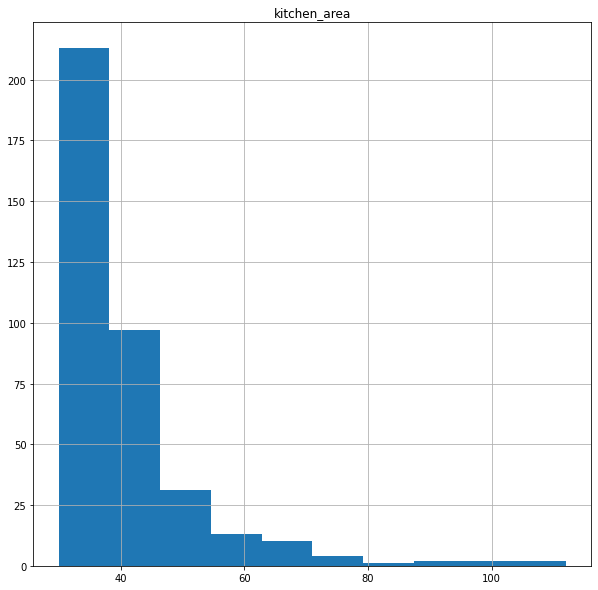

In [7]:
print('общая информация')
print(data['kitchen_area'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'kitchen_area', grid=True, figsize=(10,10), range=(30, 112))
# Преобразовываем ошибки в нормальные значения
data['kitchen_area'] = data['kitchen_area'].apply(lambda x: x / 10 if x>= 50 else x)
# Отбрасываем аномалии
data = data[~((data['kitchen_area'] > 30) & (data['kitchen_area'] < 50))]
# Заполняем пропущенные значения медианой
data['kitchen_area'].fillna(data['kitchen_area'].median(), inplace = True)

### balcony. 
Используем метод describe(). Строим гистограмму. Значения 3, 4 и 5 явно выбиваются, их мало - поэтому на результаты они вряд ли повлияют. Пропущенные значения следует заполнить 0. Скорее всего информации нету потому, что нету балкона, а это невыгодное обстоятельство для продавца. А также пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Тип данных переведен в int, 2,5 балконов не бывает.

общая информация
count    11651.000000
mean         1.154322
std          1.073222
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          5.000000
Name: balcony, dtype: float64

гистограмма по параметру


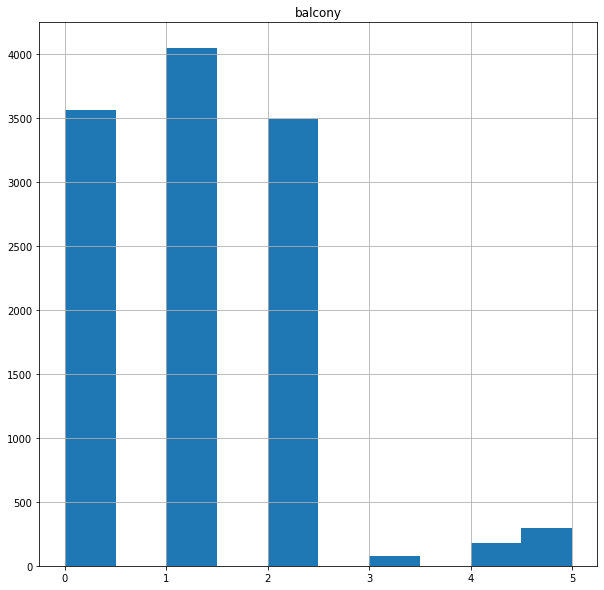

In [8]:
print('общая информация')
print(data['balcony'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'balcony', grid=True, figsize=(10,10))
# Заполняем пропущенные значения 0
data['balcony'].fillna(0, inplace = True)

### locality_name. 
Есть разные названия одних и тех же населенных пунктов. Заменим их одним общим названием. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора, их мало поэтому можем просто их убрать.

In [9]:
print('уникальные значения')
print(data['locality_name'].unique())
# Отбрасываем пропущенные значения
data.dropna(subset = ['locality_name'], inplace = True)
# Заменяем неявные дубликаты
data['locality_name'] = data['locality_name'].replace({'поселок городского типа': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'посёлок городского типа': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'посёлок': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'городской посёлок': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'городской поселок': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'коттеджный посёлок': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'коттеджный поселок': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'поселок при железнодорожной станции': 'поселок'}, regex = True)
data['locality_name'] = data['locality_name'].replace({'посёлок при железнодорожной станции': 'поселок'}, regex = True)
        

уникальные значения
['Санкт-Петербург' 'посёлок Шушары' 'посёлок Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'посёлок Парголово' 'деревня Кудрово'
 'Коммунар' 'Колпино' 'поселок городского типа Красный Бор' 'Гатчина'
 'поселок Мурино' 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский' 'Павловск'
 'деревня Пикколово' 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск'
 'Сестрорецк' 'деревня Куттузи' 'посёлок Аннино'
 'городской посёлок Янино-1' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Свет' 'деревня Оржи

### airports_nearest. 
Используем метод describe(). Строим гистограмму. Нулевых значений не очень много, так что на результаты они особо не повлияют. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    17303.000000
mean     28751.662082
std      12623.066641
min          0.000000
25%      18512.000000
50%      26726.000000
75%      37223.000000
max      84869.000000
Name: airports_nearest, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

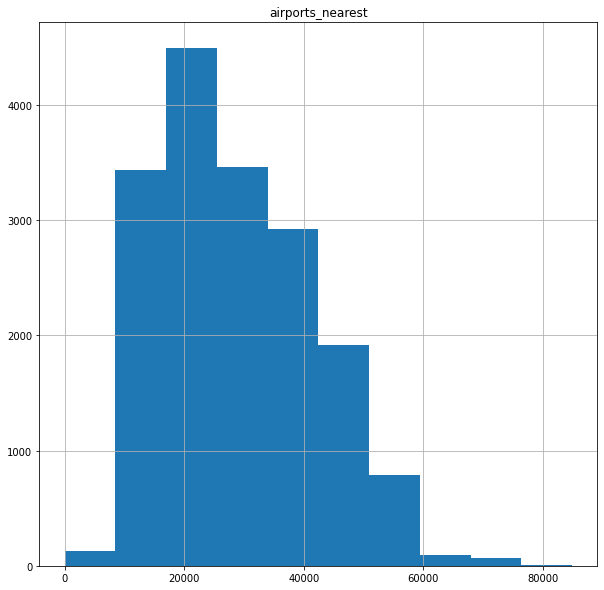

In [10]:
print('общая информация')
print(data['airports_nearest'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'airports_nearest', grid=True, figsize=(10,10))

### cityCenters_nearest. 
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, точность до сантиметров никого не интересует. Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    17325.000000
mean     14232.368254
std       8634.146489
min        181.000000
25%       9364.000000
50%      13107.000000
75%      16268.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'cityCenters_nearest'}>]],
      dtype=object)

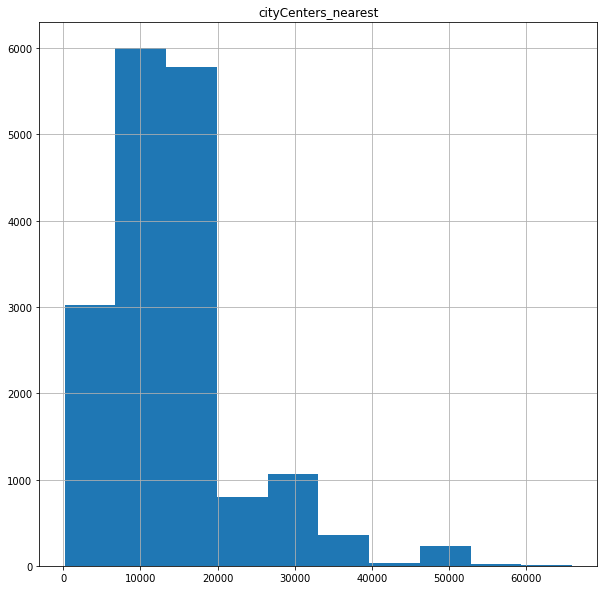

In [11]:
print('общая информация')
print(data['cityCenters_nearest'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'cityCenters_nearest', grid=True, figsize=(10,10))

### parks_around3000. 
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    17326.000000
mean         0.610124
std          0.800122
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'parks_around3000'}>]], dtype=object)

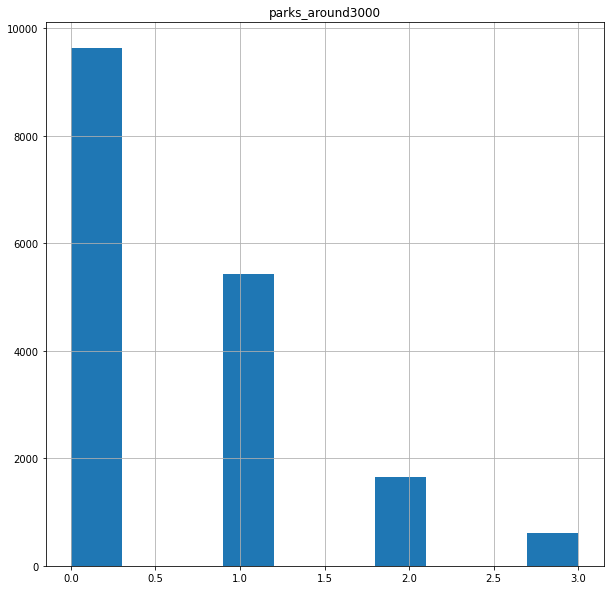

In [12]:
print('общая информация')
print(data['parks_around3000'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'parks_around3000', grid=True, figsize=(10,10))

### parks_nearest. 
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    7701.000000
mean      489.845734
std       336.793482
min         1.000000
25%       288.000000
50%       456.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'parks_nearest'}>]], dtype=object)

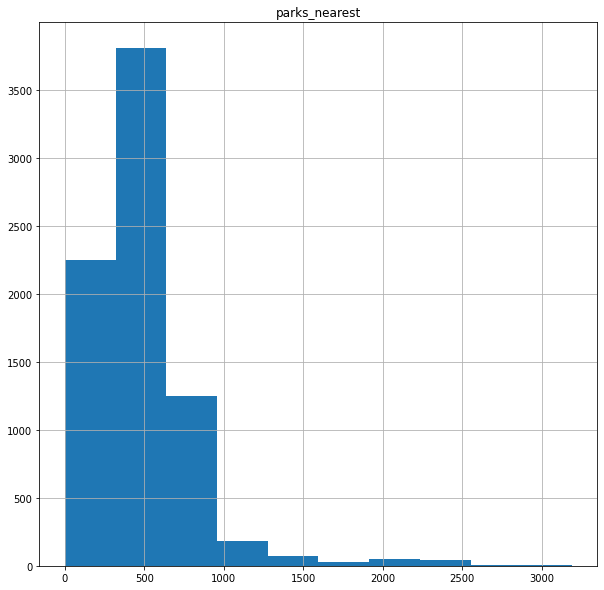

In [13]:
print('общая информация')
print(data['parks_nearest'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'parks_nearest', grid=True, figsize=(10,10))

### ponds_around3000. 
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    17326.000000
mean         0.764054
std          0.936280
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'ponds_around3000'}>]], dtype=object)

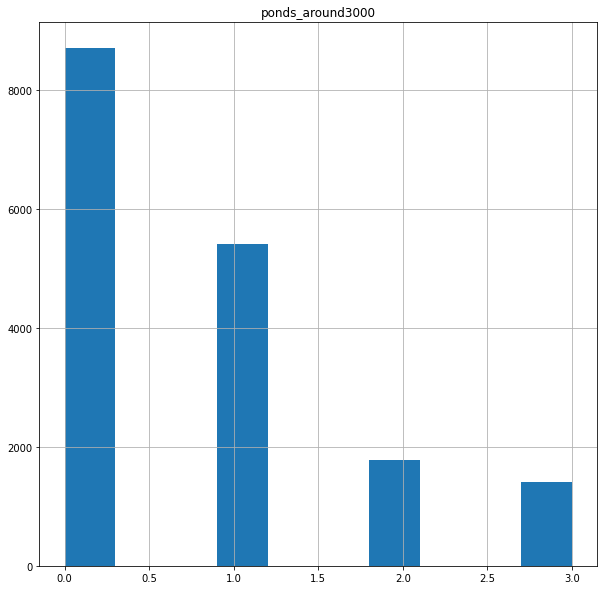

In [14]:
print('общая информация')
print(data['ponds_around3000'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'ponds_around3000', grid=True, figsize=(10,10))

### ponds_nearest. 
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, точность до сантиметров никого не интересует.

общая информация
count    8621.000000
mean      520.441712
std       277.687560
min        13.000000
25%       296.000000
50%       506.000000
75%       733.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'ponds_nearest'}>]], dtype=object)

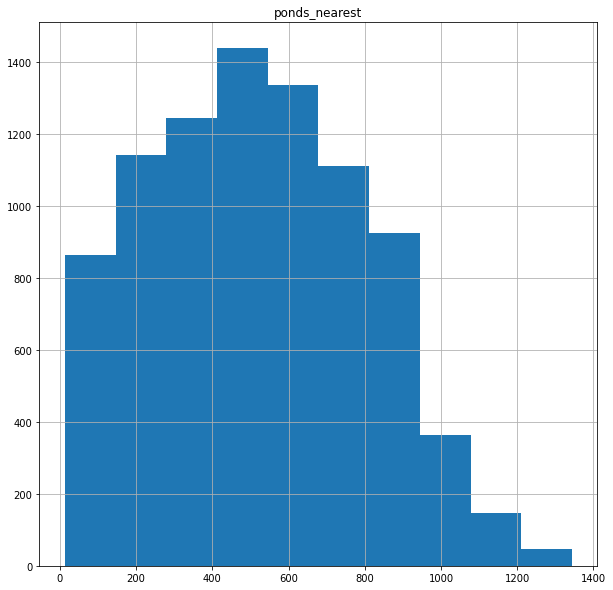

In [15]:
print('общая информация')
print(data['ponds_nearest'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'ponds_nearest', grid=True, figsize=(10,10))

### days_exposition
Используем метод describe(). Строим гистограмму. Пропущенные значения могли появится при технических неполадках или из-за человеческого фактора. Пропущенные значения можно оставить незаполненными, так как нет возможности заполнить их корректными значениями. Тип данных переведен в int, значения считаются в целых днях.

общая информация
count    19560.000000
mean       180.401431
std        218.989343
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

гистограмма по параметру


array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

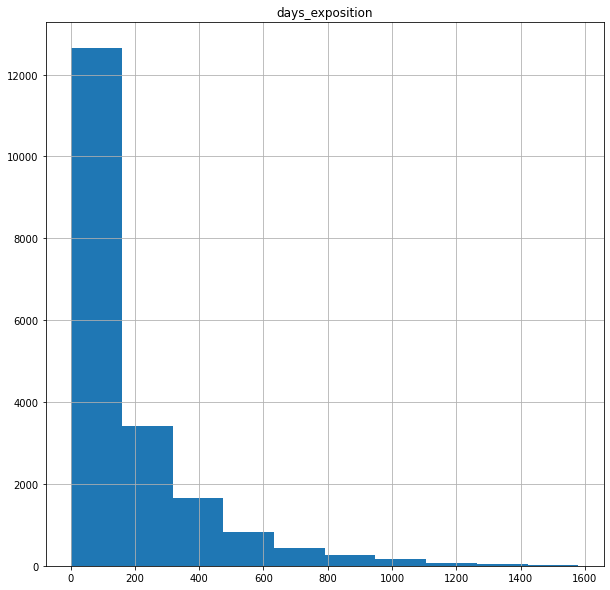

In [16]:
print('общая информация')
print(data['days_exposition'].describe())
print()
print('гистограмма по параметру')
data.hist(column = 'days_exposition', grid=True, figsize=(10,10))

### Переводим столбцы в другие виды данных 
#### first_day_exposition
Тип данных переводим из obj в datetime64. Это дата - так что переводим в вид даты.
#### balcony, floors_total, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition
Тип данных переводим из float64 в int64. Все эти значения не могут быть дробными - поэтому переводим в целочисленный тип. 

In [17]:
# Тип данных переводим из float64 в int64
data['balcony'] = pd.to_numeric(data['balcony'], downcast = 'integer')
data['floors_total'] = pd.to_numeric(data['floors_total'], downcast = 'integer')
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'], downcast = 'integer')
data['cityCenters_nearest'] = pd.to_numeric(data['cityCenters_nearest'], downcast = 'integer')
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'], downcast = 'integer')
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'], downcast = 'integer')
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'], downcast = 'integer')
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'], downcast = 'integer')
data['days_exposition'] = pd.to_numeric(data['days_exposition'], downcast = 'integer')
# Тип данных переводим из obj в datetime64
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

### Итоги раздела
#### Произведенная работа
Была произведена работа по улучшению качества данных, такие как:
##### Работа с дубликатами
Явные дубликаты не обнаружены, неявные дубликаты в столбце locality_name были устранены
##### Устранение аномалий
Устранили аномалии в столбцах ceiling_height, living_area и kitchen_area. 
##### Работа над пропущенными значениями
Устранены пропущенные значения, путем заполнения их медианным значением в столбцах: ceiling_height, living_area, kitchen_area
Пропущенные значения заменены на 0 в столбцах: balcony
Пропущенные значения заменены на False в столбцах: is_apartment
Строки с пропущенными значениями были отброшены в столбцах: floors_total, locality_name
Пропущенные значения остались нетронутыми, в связи с невозможностью их заполнения корректным значением, без искажения данных в столбцах: airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition
##### Изменение типов данных 
Такие столбцы, как: balcony, floors_total, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition были переведены в целочисленный формат int64. 
Столбец first_day_exposition был переведен в формат даты datetime64.
#### Вывод
Произведенная работа по улучшению качества данных была произведена в объеме, достаточном для будущего анализа данных, выведении закономерностей и построении конечных выводов.

## Посчитайте и добавьте в таблицу новые столбцы

In [18]:
# Добавляем столбец с ценой одного квадратного метра
data['price_of_metre'] = data['last_price']/data['total_area']

# Добавляем столбец с днем недели публикации объявления, я сделал нагляднее - будет выведен день недели, а не номер дня недели.
# Номер дня недели потребуется позже - там его я и использовал.
data['day_of_week'] = data['first_day_exposition'].dt.day_name()
data['day_of_week_number'] = data['first_day_exposition'].dt.day

# Добавляем столбец с месяцем публикации объявления
data['month'] = data['first_day_exposition'].dt.month

# Добавляем столбец с годом публикации объявления
data['year'] = data['first_day_exposition'].dt.year

# Добавляем столбец с типом этажа квартиры (значения — «первый», «последний», «другой»)
data['type_of_floor'] = data.apply(lambda x: 'первый' if x['floor'] == 1 else ('последний' if x['floor'] == x['floors_total'] else 'другой'), axis=1)

# Добавляем столбец с расстоянием до центра города в километрах (переведите из м в км и округлите до целых значений)
data['distance_to_center_km'] = data['cityCenters_nearest']/1000



## Проведите исследовательский анализ данных

### total_area
Большинство значений находится от 30 до 70 кв.м. Так же присутствуют квартиры площадь которых больше 500 кв.м., но их крайне мало.


общая информация


count    22594.000000
mean        60.047925
std         33.659443
min         13.000000
25%         40.900000
50%         52.500000
75%         69.500000
max        900.000000
Name: total_area, dtype: float64

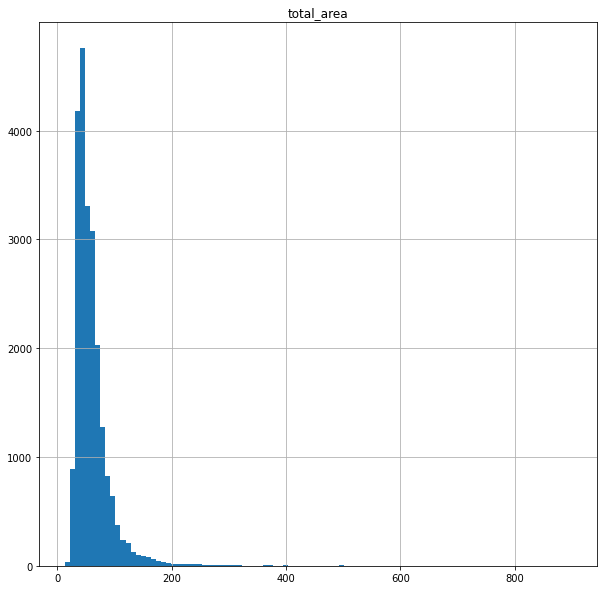

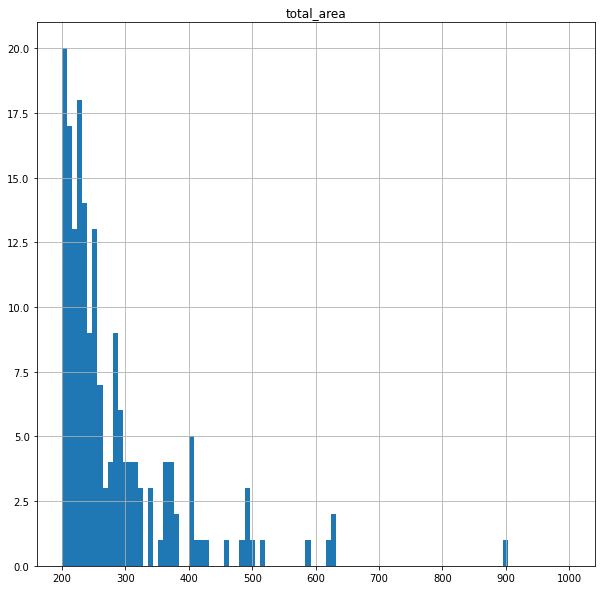

In [19]:
data.hist(column = 'total_area', grid=True, figsize=(10,10), bins = 100)
data.hist(column = 'total_area', grid=True, figsize=(10,10), range=(200,1000), bins = 100)
print()
print('общая информация')
data['total_area'].describe()

count    22594.000000
mean        60.047925
std         33.659443
min         13.000000
25%         40.900000
50%         52.500000
75%         69.500000
max        900.000000
Name: total_area, dtype: float64

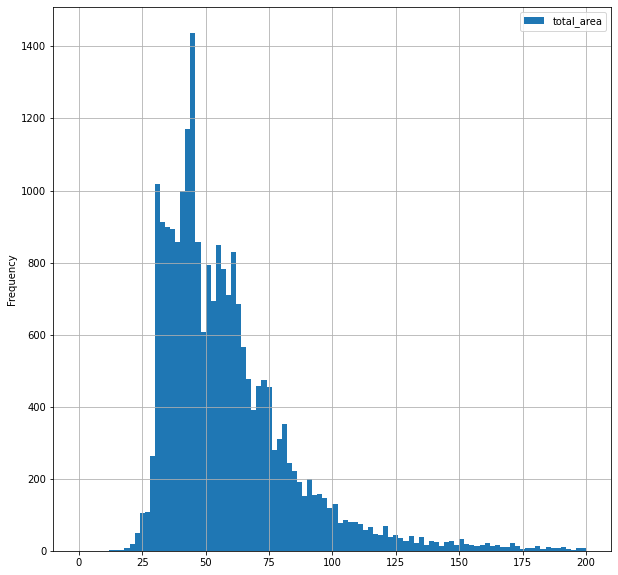

In [20]:
#Код ревьюера
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (10,10), range = (0,200))
data['total_area'].describe()

### living_area
Большинство значений находится от 15 до 50 кв.м. Так же присутствуют квартиры жилая площадь которых больше 200 кв.м., но их крайне мало.


общая информация


count    22594.000000
mean        34.381295
std         20.257985
min         15.000000
25%         20.000000
50%         30.500000
75%         41.500000
max        409.700000
Name: living_area, dtype: float64

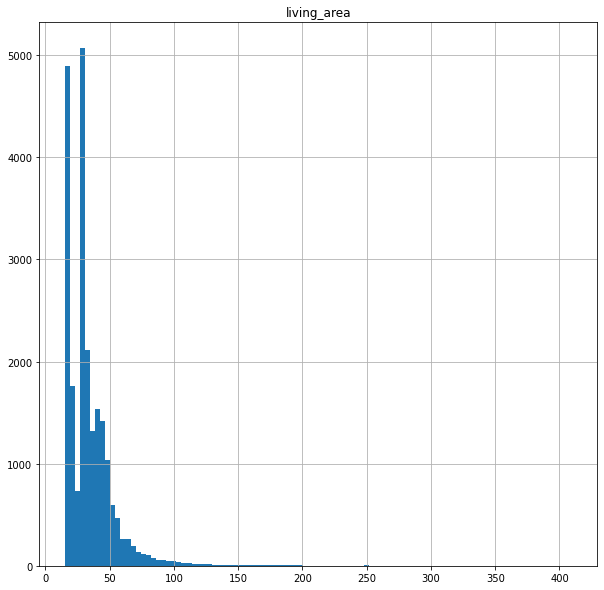

In [21]:
data.hist(column = 'living_area', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['living_area'].describe()

### kitchen_area
Большинство значений находится от 5 до 12 кв.м. Исходя из вышеперечисленного можно сделать вывод, что кухня и жилая площадь в большинстве случаев это еще не вся квартира. 


общая информация


count    22594.000000
mean         9.931483
std          3.981976
min          1.300000
25%          7.200000
50%          9.000000
75%         11.100000
max         30.000000
Name: kitchen_area, dtype: float64

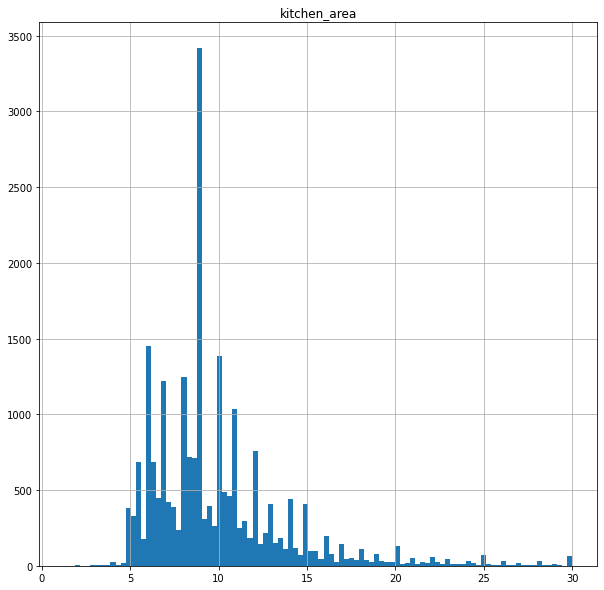

In [22]:
data.hist(column = 'kitchen_area', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['kitchen_area'].describe()

### last_price
Большинство квартир стоит от 2 до 8 млн. А абсолютным рекордсменом стала квартира за 763 млн c аж семью комнатами.


общая информация


count    2.259400e+04
mean     6.357466e+06
std      9.956913e+06
min      4.300000e+05
25%      3.450000e+06
50%      4.650000e+06
75%      6.750000e+06
max      7.630000e+08
Name: last_price, dtype: float64

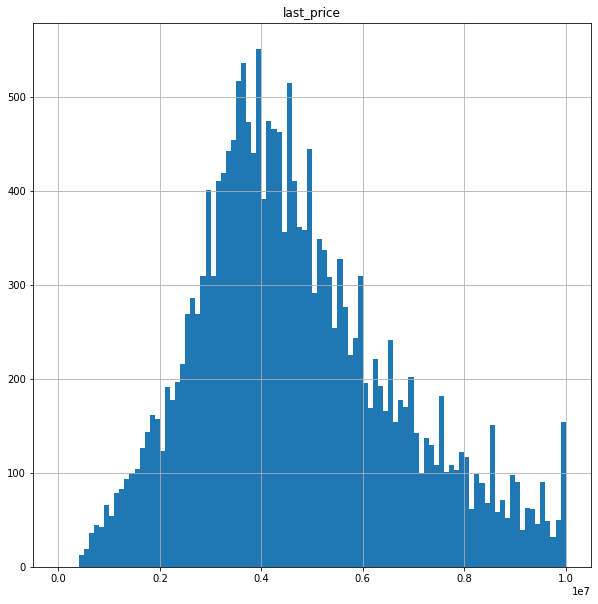

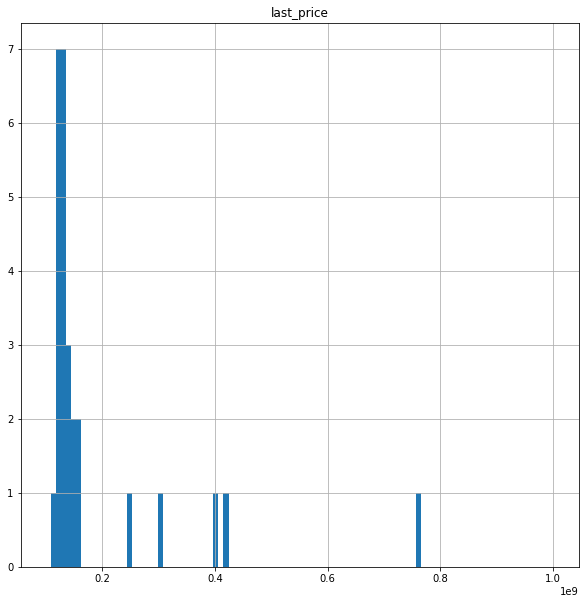

In [23]:
data.hist(column = 'last_price', grid=True, figsize=(10,10), range=(0, 10000000), bins = 100)
data.hist(column = 'last_price', grid=True, figsize=(10,10), range=(100000000,1000000000), bins = 100)
print()
print('общая информация')
data['last_price'].describe()

### rooms
Большинство квартир имеет от 0 до 3 комнат. Исходя из вывода по last_price думаю, что комнаты у которых 10 и больше комнат - это ошибка в данных. 10 и 20 комнат скорее всего представляют собой 1 и 2 комнат. Кол-во аномальных значений крайне мало - думаю что на финальные выводы они не повлияют.


общая информация


count    22594.000000
mean         2.089094
std          1.067078
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

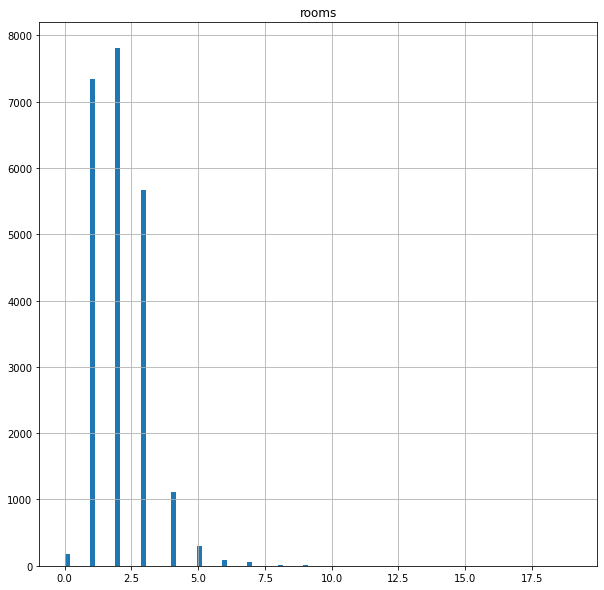

In [24]:
data.hist(column = 'rooms', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['rooms'].describe()

### ceiling_height
Большинство значений в промежутке от 2,5 до 3 метров.


общая информация


count    22594.000000
mean         2.694128
std          0.214948
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

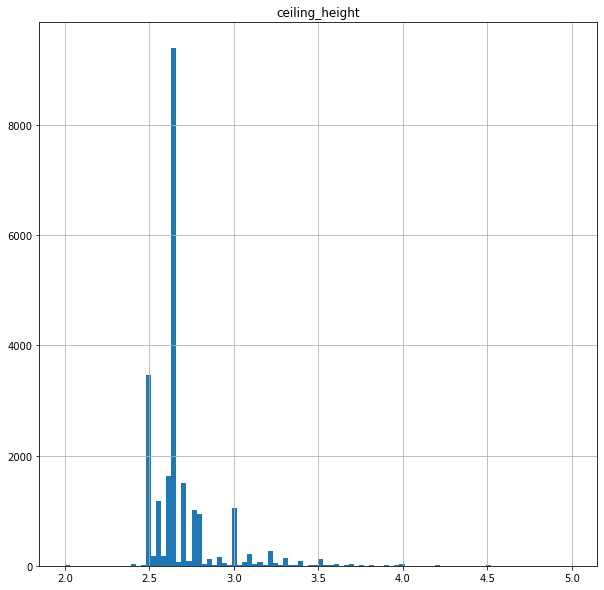

In [25]:
data.hist(column = 'ceiling_height', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['ceiling_height'].describe()

### floor
Большинство квартир продается с 1 по 15 этаж. Видимо в Санкт-Петербурге не очень много высокоэтажных зданий, либо никто не хочет продавать квартиры, которые выше. 


общая информация


count    22594.000000
mean         5.811145
std          4.817022
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

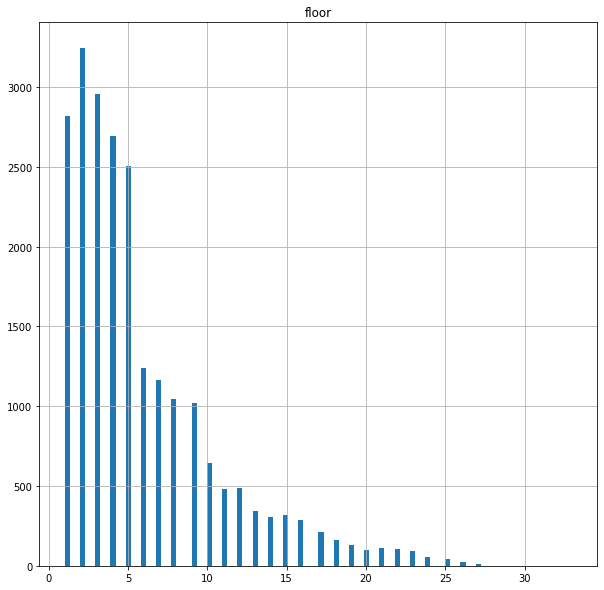

In [26]:
data.hist(column = 'floor', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['floor'].describe()

### type_of_floor
Около 73% всех квартир это не первый и не последний этаж.

общая информация


count      22594
unique         3
top       другой
freq       16569
Name: type_of_floor, dtype: object

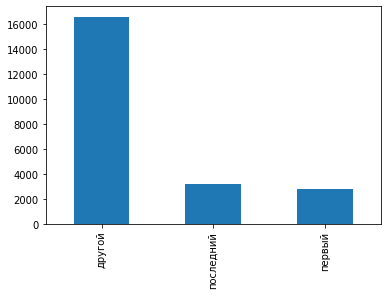

In [27]:
data['type_of_floor'].value_counts().plot(kind='bar')
print('общая информация')
data['type_of_floor'].describe()

### floors_total
Большинство домов имеют от 5 до 18 этажей. 


общая информация


count    22594.000000
mean        10.559927
std          6.521676
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         60.000000
Name: floors_total, dtype: float64

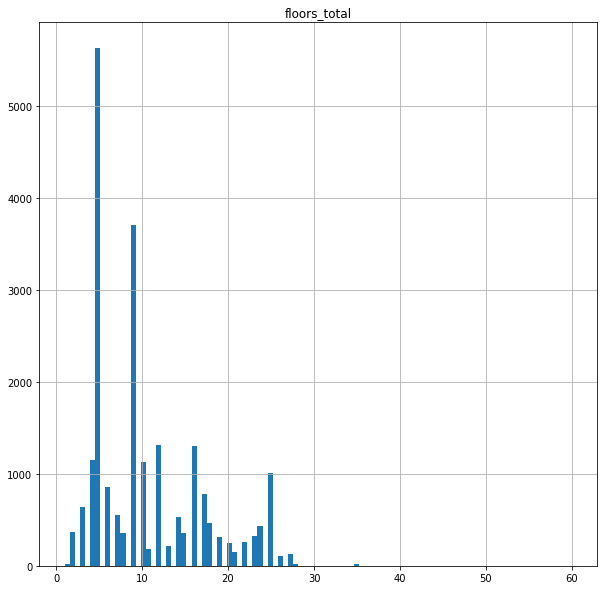

In [28]:
data.hist(column = 'floors_total', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['floors_total'].describe()

### cityCenters_nearest
Большинство квартир находятся от 5 до 20 км от центра. Видимо никто не хочет продавать квартиры в центре, либо их там просто нет.


общая информация


count    17325.000000
mean     14232.368254
std       8634.146489
min        181.000000
25%       9364.000000
50%      13107.000000
75%      16268.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

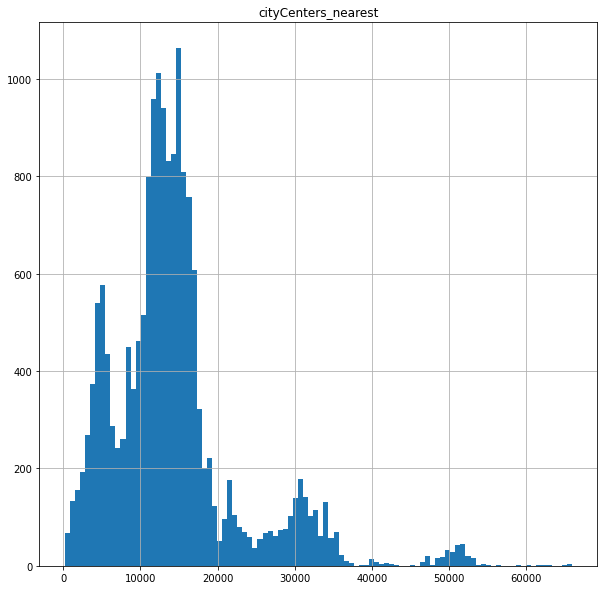

In [29]:
data.hist(column = 'cityCenters_nearest', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['cityCenters_nearest'].describe()

### airports_nearest
Большинство квартир, которые продаются, находятся от 10 до 40 км от аэропорта. У них довольно неплохое расположение для тех, кто любит путешествовать - аэропорт не будет слышно каждый день, но он и не так далеко от домов.


общая информация


count    17303.000000
mean     28751.662082
std      12623.066641
min          0.000000
25%      18512.000000
50%      26726.000000
75%      37223.000000
max      84869.000000
Name: airports_nearest, dtype: float64

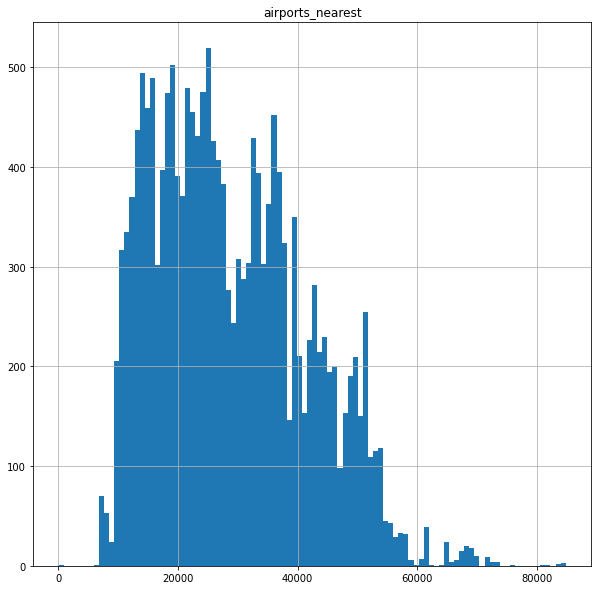

In [30]:
data.hist(column = 'airports_nearest', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['airports_nearest'].describe()

### parks_nearest
Большинство домов находится в 450 метрах от парка. Вероятно в городе очень много парков.


общая информация


count    7701.000000
mean      489.845734
std       336.793482
min         1.000000
25%       288.000000
50%       456.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

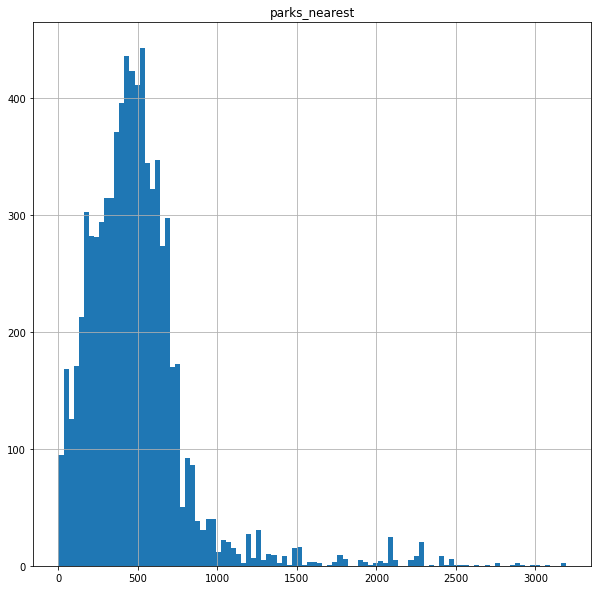

In [31]:
data.hist(column = 'parks_nearest', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['parks_nearest'].describe()

### day_of_week
Большинство объявлений выставляются в будние дни. Вероятно выходные на то и выходные, что на них не работают.

общая информация


Thursday     4110
Tuesday      4000
Friday       3814
Wednesday    3786
Monday       3422
Saturday     1844
Sunday       1618
Name: day_of_week, dtype: int64

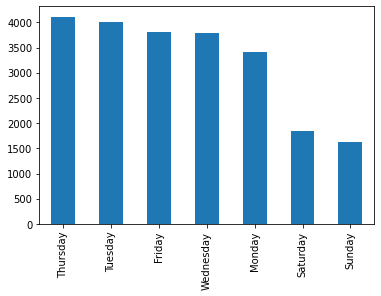

In [32]:
data['day_of_week'].value_counts().plot(kind='bar')
print('общая информация')
data['day_of_week'].value_counts()

### month
Декабрь и Январь - время для нового года. А вот время для выставления квартиры на продажу 2-3 месяца до и после, Декабря и Января соотвественно.


общая информация


2     2538
3     2476
11    2265
4     2252
10    2001
9     1886
8     1683
6     1680
7     1602
12    1586
1     1421
5     1204
Name: month, dtype: int64

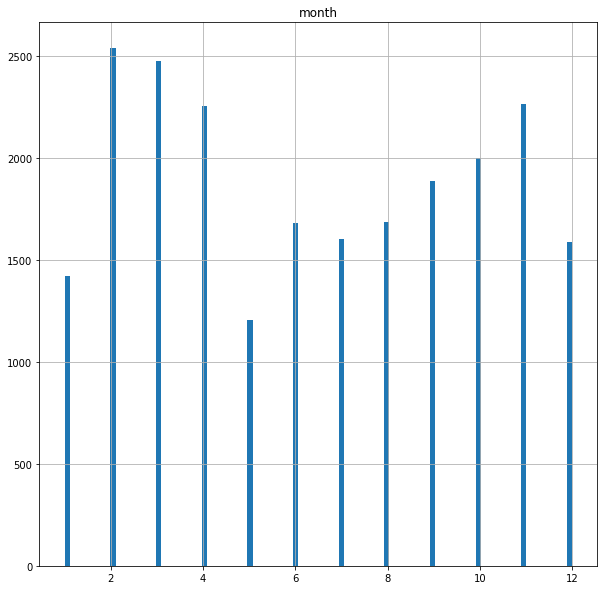

In [33]:
data.hist(column = 'month', grid=True, figsize=(10,10), bins = 100)
print()
print('общая информация')
data['month'].value_counts()

### Изучите, как быстро продавались квартиры 
Большая часть квартир продается меньше чем за 100 дней. Но именно быстрыми продажами можно назвать те, которые совершаются до первого квантиля, а именно за 45 дней и меньше. Думаю долгим можно считать значения после второго квантиля, а именно 230 дней и более. Дополнительно можно отметить что период в 230 дней затрагивает два самых активных периода по продажам (из выводов по параметру month) - тогда можно сказать, что квартира действительно долго продается.

общая информация
count    19560.000000
mean       180.401431
std        218.989343
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

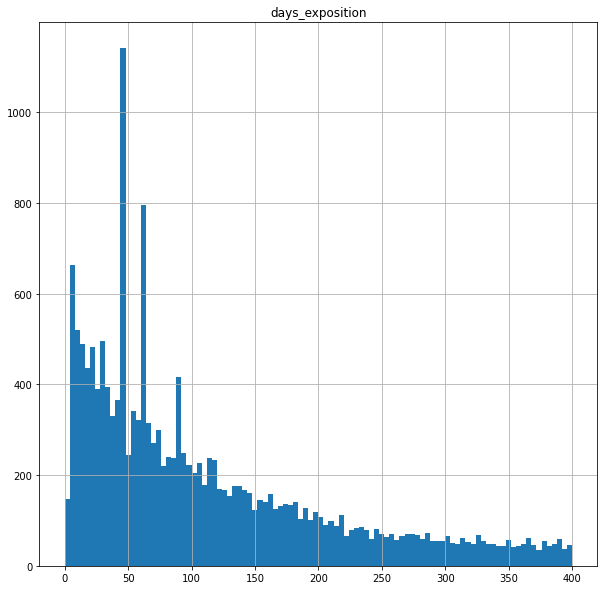

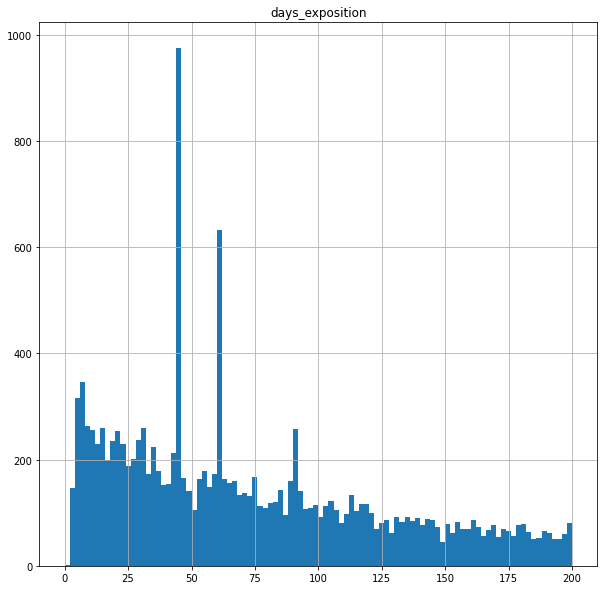

In [34]:
#Первое задание
print('общая информация')
print(data['days_exposition'].describe())
# Строим гистограмму для большинства значений
data.hist(column = 'days_exposition', grid=True, figsize=(10,10), range=(0,400), bins = 100)
# Строим гистограмму для значений в промежутке до второго квантиля
data.hist(column = 'days_exposition', grid=True, figsize=(10,10), range=(0,200), bins = 100)

### Какие факторы больше всего влияют на общую (полную) стоимость объекта
Посчитав сначала коэффициент корреляции Пирсона - выяснили, что ни от дня недели, ни от месяца, ни от года общая стоимость не зависит. Очень слабо коррелирует общая цена с количеством комнат или площадью кухни. Самыми интересными с точки зрения корреляции можно выделить такие параметры, как: living_area и total_area, имеющие 0,65 и 0,54 соответственно. Построим графики по living_area и total_area, а также kitchen_area и rooms. Графики подтвердили, что kitchen_area и rooms не имеют корреляцию с last_price. Трудно сказать коррелирует ли total_area или нет, выглядит так - будто бы корреляция слабая. А вот living_area выделяется среди всех своей пусть и не впечатляющей, но корреляцией с last_price.

Коэффициент корреляции Пирсона между last_price и total_area
0.6523139416680653
Коэффициент корреляции Пирсона между last_price и living_area
0.5435928275039295
Коэффициент корреляции Пирсона между last_price и kitchen_area
0.3017420166046283
Коэффициент корреляции Пирсона между last_price и rooms
0.36271712690155494
Коэффициент корреляции Пирсона между last_price и first_day_exposition
-0.0010355363836734228
Коэффициент корреляции Пирсона между last_price и month
0.008143104247943888
Коэффициент корреляции Пирсона между last_price и year
-0.04401219429722115


<AxesSubplot:xlabel='year', ylabel='last_price'>

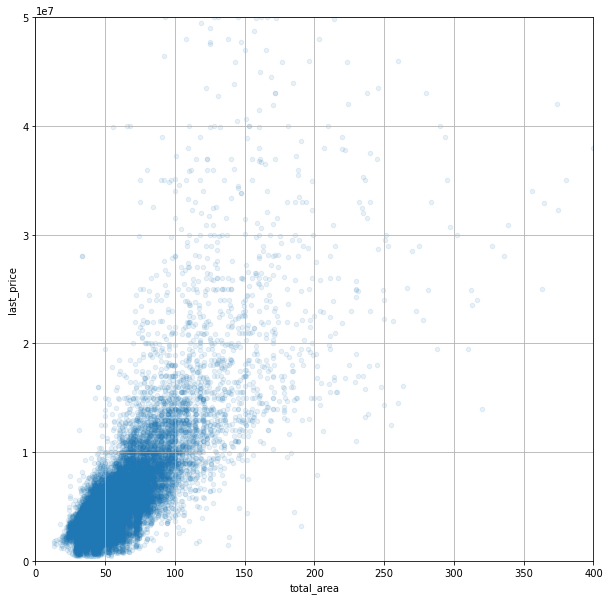

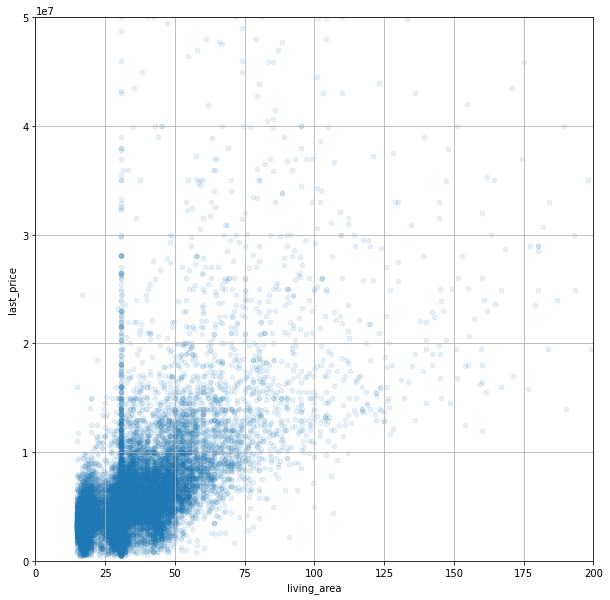

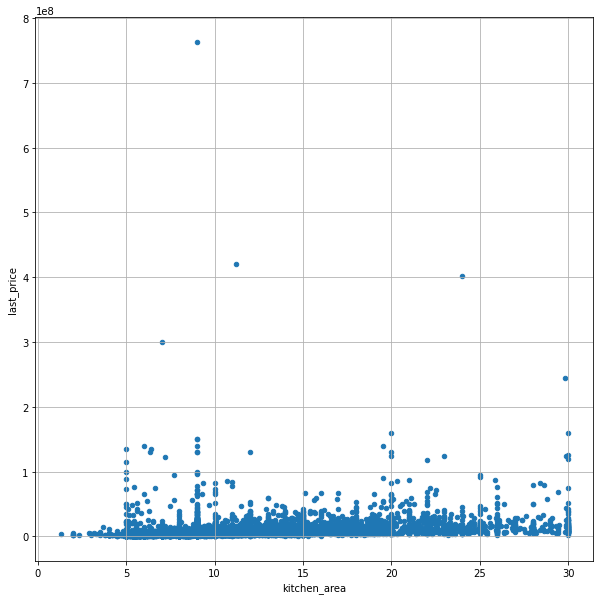

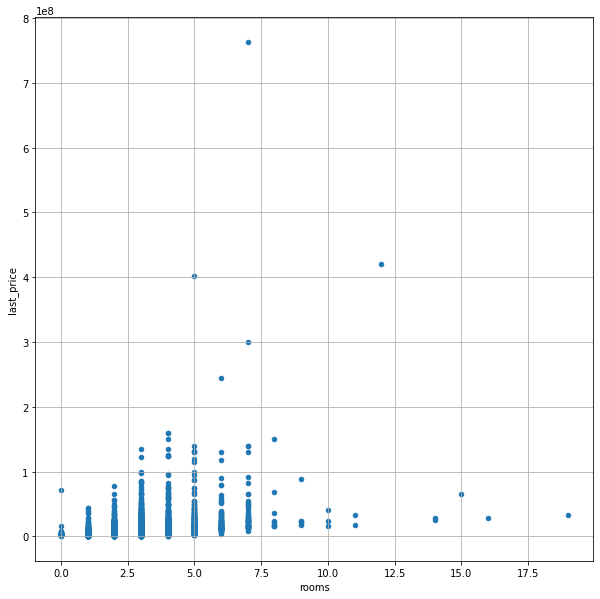

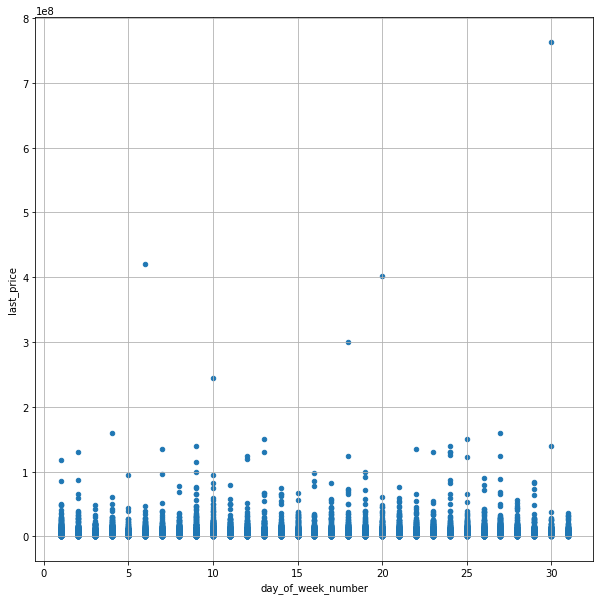

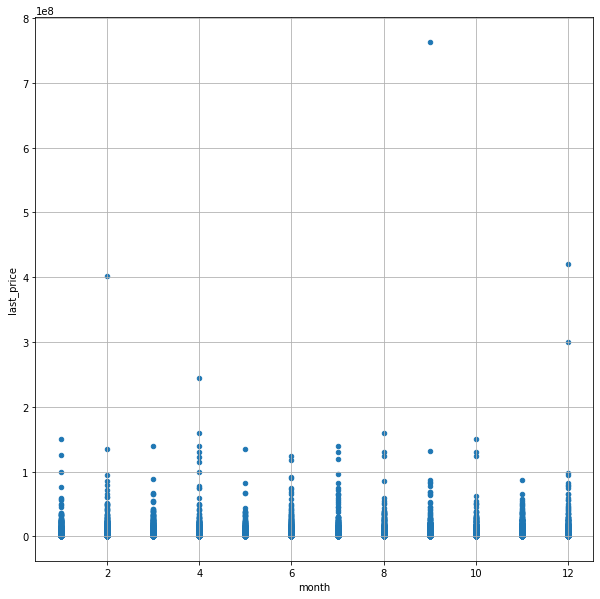

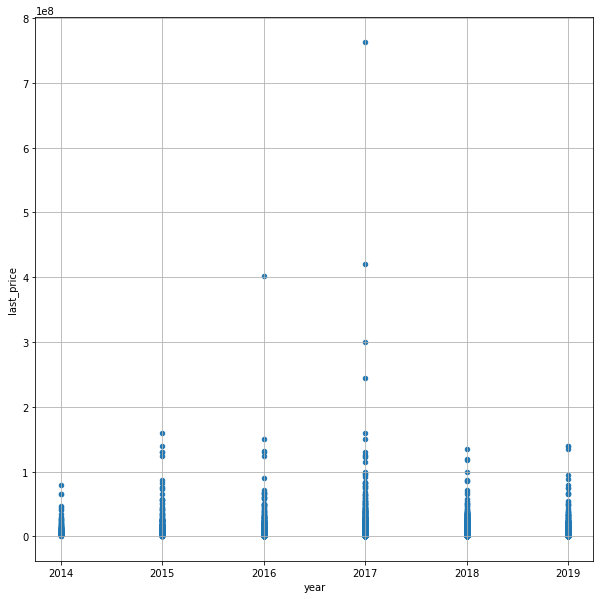

In [35]:
#Второе задание
print('Коэффициент корреляции Пирсона между last_price и total_area')
print(data['last_price'].corr(data['total_area']))

print('Коэффициент корреляции Пирсона между last_price и living_area')
print(data['last_price'].corr(data['living_area']))

print('Коэффициент корреляции Пирсона между last_price и kitchen_area')
print(data['last_price'].corr(data['kitchen_area']))

print('Коэффициент корреляции Пирсона между last_price и rooms')
print(data['last_price'].corr(data['rooms']))

print('Коэффициент корреляции Пирсона между last_price и first_day_exposition')
print(data['last_price'].corr(data['first_day_exposition'].dt.weekday))

print('Коэффициент корреляции Пирсона между last_price и month')
print(data['last_price'].corr(data['month']))

print('Коэффициент корреляции Пирсона между last_price и year')
print(data['last_price'].corr(data['year']))

# Строим диаграмму рассеяния для total_area и last_price
data.plot(x='total_area', y='last_price', kind='scatter', figsize = (10,10), alpha = 0.1, grid = True, xlim = (0,400), ylim = (0,50000000))
# Строим диаграмму рассеяния для living_area и last_price
data.plot(x='living_area', y='last_price', kind='scatter', figsize = (10,10), alpha = 0.1, grid = True, xlim = (0,200), ylim = (0,50000000))
# Строим диаграмму рассеяния для kitchen_area и last_price
data.plot(x='kitchen_area', y='last_price', kind='scatter', figsize = (10,10), grid = True)
# Строим диаграмму рассеяния rooms и last_price
data.plot(x='rooms', y='last_price', kind='scatter', figsize = (10,10), grid = True)

# Строим диаграмму рассеяния днем недели и last_price
data.plot(x='day_of_week_number', y='last_price', kind='scatter', figsize = (10,10), grid = True)
# Строим диаграмму рассеяния month и last_price
data.plot(x='month', y='last_price', kind='scatter', figsize = (10,10), grid = True)
# Строим диаграмму рассеяния year и last_price
data.plot(x='year', y='last_price', kind='scatter', figsize = (10,10), grid = True)

### Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
Для наглядности первым делом вывел себе список 10 населённых пунктов с наибольшим числом объявлений. Воспользуемся pivot_table - сгруппируем значения по locality_name, дадим значения из столбца price_of_metre посчитаем кол-во и среднее. Уберем двойное нумерование столбцов и отсортируем данные, а также выведем 10 значений. Самая высокая цена за квадратный метр в Санкт-Петербурге. Самой низкой ценой из нашей выборки в 10 значений обладает Выборг. Но самой низкой ценой по всем данным обладает деревня Старополье.

десять населенных пунктов с наибольшим числом объявлений
locality_name
Санкт-Петербург      15032
поселок Мурино         485
поселок Шушары         405
Всеволожск             376
Пушкин                 356
Колпино                331
Гатчина                303
деревня Кудрово        281
поселок Парголово      277
Выборг                 233
Name: ceiling_height, dtype: int64

десять населенных пунктов с наименьшей средней ценой одного квадратного метра
                         count          mean
locality_name                               
деревня Старополье           3  11206.221198
поселок станции Свирь        2  11481.481481
деревня Вахнова Кара         1  11688.311688
деревня Выскатка             2  12335.480902
поселок Совхозный            2  12629.129129
деревня Малая Романовка      1  12724.550898
поселок Тёсово-4             1  12931.034483
деревня Сижно                1  13709.677419
деревня Ям-Тесово            2  13711.553373
поселок Житково              2  14956.275202

деся

<AxesSubplot:xlabel='locality_name'>

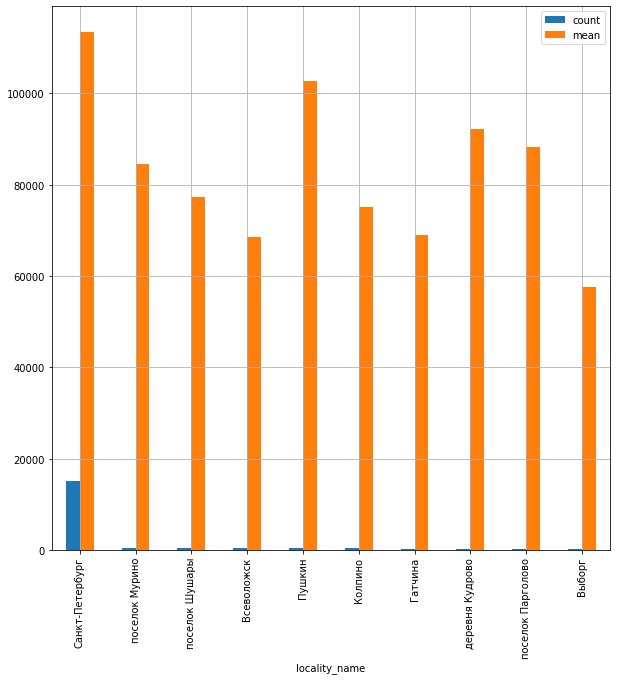

In [36]:
#Третье задание
print('десять населенных пунктов с наибольшим числом объявлений')
# десять населенных пунктов с наибольшим числом объявлений для наглядности
print(data.groupby('locality_name')['ceiling_height'].count().sort_values(ascending = False).head(10))
mean_price_for_locals = data.pivot_table(index = 'locality_name', values = 'price_of_metre', aggfunc=['count', 'mean'])
mean_price_for_locals.columns = ['count','mean']
print()
print('десять населенных пунктов с наименьшей средней ценой одного квадратного метра')
print(mean_price_for_locals.sort_values(by = 'mean').head(10))
print()
print('десять населенных пунктов с наибольшим числом объявлений и средней ценой одного квадратного метра')
print(mean_price_for_locals.sort_values(by = 'count', ascending = False).head(10))
# Добавляем визуализацию результатов, где показаны count и mean по выбранным параметрам
mean_price_for_locals.sort_values(by = 'count', ascending = False).head(10).plot(kind = 'bar', grid = True, figsize=(10,10))

### Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра
Сортируем нужные нам значения, считаем среднюю цену каждого километра и строим график. На графике явно видно, что средняя цена за километр от центра тем ниже, чем дальше квартира от центра. Самые дорогие квартиры в Санкт-Петербурге те, которые находятся от центра не дальше чем 7,5 км. Чем ближе к центру города тем дороже квартиры, и наоборот - чем дальше квартира находится от города тем она дешевле.

таблица зависимости средней цены в зависимости от дистанции до центра города
                             mean
                       last_price
distance_to_center_km            
0.181                  31099000.0
0.208                   5800000.0
0.215                  10990000.0
0.287                   9590000.0
0.291                  11500000.0
...                           ...
28.644                  4775000.0
28.806                  4370000.0
29.263                  4850000.0
29.343                  4200000.0
29.493                  2450000.0

[6193 rows x 1 columns]



<AxesSubplot:xlabel='distance_to_center_km'>

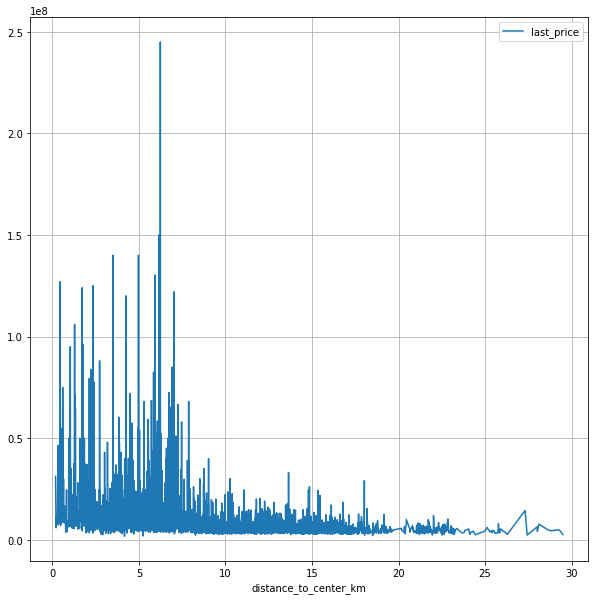

In [37]:
#Четвертое задание
data_spb = data[data['locality_name'] == 'Санкт-Петербург']
print('таблица зависимости средней цены в зависимости от дистанции до центра города')
print(data_spb.pivot_table(index = 'distance_to_center_km', values = 'last_price', aggfunc=['mean']))
print()
data_spb.groupby('distance_to_center_km')['last_price'].median().plot(legend = True, figsize=(10,10), grid = True)

## Общий вывод

### Предобработка данных
Качество данных возросло, благодаря:
* Устранению неявных дубликатов
* Устранению аномалий в данных
* Обработаны все пропущенные значения в датасете
* Тип данных был изменен там, где это было необходимо
### Добавление новых данных
На основе имеющегося датасета были расчитаны новые параметры, которые значительно помогли оценить ситуацию по продажам квартир в Санкт-Петербурге
### Исследовательский анализ данных 
Исследовательский анализ данных был произведен в полном объеме и включал в себя:
* анализ большинства имеющихся параметров
* анализ конкретных запросов заказчика
#### Исследование отдельных параметров
Были найдены некоторые закономерности:
* очень много объявлений о продаже квартир с площадью меньше 100 кв.м.. Квартиры с площадью больше чем 100 кв.м. считаются премиум сегментом. 
* большая часть цен варьируется от 2 до 8 млн. рублей. И большинство квартир имеет не больше 3 комнат. А с учетом того, что большинство выставленных на продажу квартир находится в домах с кол-вом этажей от 5 до 18, то можно сделать вывод, что выставлены квартиры в многоквартирных домах.
* преобладающая часть квартир имеет очень хорошее расположение, что несомненно влияет на их цену. Они находятся недалеко от центра - всего лишь в 5-20 км. Сравнительно недалеко от аэропорта - от 10 до 40 км, а это меньше часа езды на машине. При этом сам аэропорт слышен не будет. Вокруг домов очень много парков на расстоянии 0,5 км., а это меньше чем 10 минут ходьбы. 
* в праздничное меясцы выставлялось меньше предложений.
#### Исследование запросов заказчика
Задачи выполнены в полном объеме и были получены следующие результаты:
* большая часть квартир продается меньше чем за 100 дней. Быстрыми продажами можно назвать те которые совершаются за 45 дней и меньше. Долгим можно считать продажи за 230 дней и более.
* основное влияние на конечную цену имеет жилая площадь. Судя по всему, большинство при покупке и продаже квартиры руководствуются именно этим параметром. Общая площадь квартиры при этом имеет чуть меньшее значение для людей, но, тем не менее, имеет.
* большинство объявлений приходится на Санкт-Петербург. В этом же городе самая высокая средняя цена на квартиру.
* квартира тем дороже, чем ближе она к центру города. И наоборот - чем дальше она центра, тем она дешевле. В радиусе 7,5 км от центра города находятся самые дорогие квартиры.
### Итог
Работа была произведена в полном объеме, все поставленные задачи были выполнены.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод